# 卷积实现手写数字体识别
- 本demo主要通过卷积的方式实现
- 本demo没有使用keras等高层api

### 1.库及函数准备
- 导入相关package tf
- 定义了2个函数，weight_variable/bias_variable，分别用来后续初始化w，b
- 定义了2个函数，conv2d/max_pool_2x2，分别用来做卷积和池化
- 本demo会话开启，使用的是交互式的`sess = tf.InteractiveSession()`,请注意这种方式的使用语法

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf 

#导入数据，创建一个session对象　，之后的运算都会跑在这个session里
mnist = input_data.read_data_sets("data/MNIST/",one_hot=True)
sess = tf.InteractiveSession()     #交互式的session可以在里面写计算图

#定义一个函数，用于初始化所有的权值 W,这里我们给权重添加了一个截断的正态分布噪声　标准差为0.1
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

#定义一个函数，用于初始化所有的偏置项 b，这里给偏置加了一个正值0.1来避免死亡节点
def bias_variable(shape):
    inital = tf.constant(0.1,shape=shape)
    return tf.Variable(inital)

#定义一个函数，用于构建卷积层，这里strides都是１　代表不遗漏的划过图像的每一个点
def conv2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')      #表示输出与输入图的大小保持不变

#定义一个函数，用于构建池化层
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\MNIST\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\MNIST\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data\MNIST\t10k-images-idx3-ubyte.gz
Extracting data\MNIST\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### 2. 定义计算图的输入部分
- 本例中用到了`tf.placeholder()`占位符，占位符使用时，请注意参数中的`dtype`必须指定
- 下面的代码将11 feed 给 a
```python
tf.placeholder(dtype, shape=None, name=None)
a = tf.placeholder(shape=[],dtype=tf.int32,name='a') #必须指定的是dtype
print(a)
with tf.Session() as sess:
    print(sess.run(a,feed_dict={a:11}))
```

In [5]:
#placceholder 基本都是用于占位符　后面用到先定义

#将数据reshape成适合的维度来进行后续的计算
x = tf.placeholder(tf.float32,[None,784])#
y_ = tf.placeholder(tf.float32,[None,10])
x_image = tf.reshape(x,[-1,28,28,1]) #其中的-1表示“目前不确定”，所以在运行的时候程序先考虑后面的28,28和1
print(x_image)

Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)


### 3. 网络定义
- 注意w，b的参数维度设置
- 注意激活的位置
- 注意softmax的位置
- 简单推导下所需要的参数数量

In [6]:
#第一个卷积层的定义
#Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
#and a filter / kernel tensor of shape
#`[filter_height, filter_width, in_channels, out_channels]
W_conv1 = weight_variable([5,5,1,32])  #参数是shape                              
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1) + b_conv1)               #卷积计算，激活函数为relu
h_pool1 = max_pool_2x2(h_conv1)                           #参数是池化的对象

#第二个卷积层的定义
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#第一个全连接层的定义
h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])   #压平，展开
W_fc1 = weight_variable([7*7*64,1024])   #全连接层输入x输出个权重
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1)

#将第一个全连接层　进行dropout　随机丢掉一些神经元不参与运算
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)  #丢掉一些神经元

#第二个全连接层　分为十类数据　softmax后输出概率最大的数字
W_fc2 = weight_variable([1024,10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv),reduction_indices=[1]))        #交叉熵
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)             #这里用Ａdam优化器优化　也可以使用随机梯度下降

correct_predition = tf.equal(tf.argmax(y_conv,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_predition,tf.float32))                                #准确率

tf.initialize_all_variables().run()  
#sess.run(tf.initialize_all_variables())#使用全局参数初始化器　并调用run方法　来进行参数初始化

tf.summary.scalar('accuracy',accuracy)## 将accuracy的结果写入tensorboard可视化工具
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter("data/MNIST/board",sess.graph)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


### 4.开始训练并用测试集测试精度
- 再次注意当使用`sess = tf.InteractiveSession()`时，开启计算会话的方式,下面俩种都可以
   - `train_accuracy = accuracy.eval(feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})`
   - `train_accuracy = sess.run(accuracy,feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})`

In [7]:
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})        #每一百次打印一下准确率
        print("step %d,training accuracy %g"%(i,train_accuracy))
        train_summary = sess.run(merged, feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
        train_writer.add_summary(train_summary,i)

    train_step.run(feed_dict={x:batch[0],y_:batch[1],keep_prob:0.5})          #train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)  
    #sess.run(xxxxxxxxxxx)

print ("test accuracy %g"%accuracy.eval(feed_dict={x:mnist.test.images[:50],y_:mnist.test.labels[:50],keep_prob:1.0}))    #开始测试数据

step 0,training accuracy 0.1
step 100,training accuracy 0.7
step 200,training accuracy 0.88
step 300,training accuracy 0.98
step 400,training accuracy 0.92
step 500,training accuracy 0.96
step 600,training accuracy 0.94
step 700,training accuracy 0.94
step 800,training accuracy 0.88
step 900,training accuracy 0.98
test accuracy 0.9599


### 5. 使用自己手写的图片验证
- 此例同demo01

In [2]:
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
(28, 28, 3)
(28, 28)


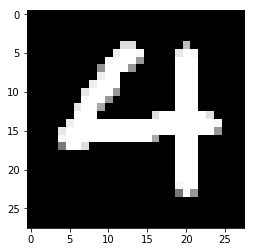

(1, 784)

In [3]:
def make_label(label_num):
    label = np.zeros((1, 10),dtype='float32')
    label[:,label_num] = 1.0
    print(label)
    return label

label_test = make_label(4)
# 图片路径
img_path = "data/MNIST_test/4.png"
img_file = cv2.imread(img_path)
print(img_file.shape)
img_file = cv2.cvtColor(img_file, cv2.COLOR_RGB2GRAY)
print(img_file.shape)
img_file = 255 - img_file
for row in range(img_file.shape[0]):
    for col in range(img_file.shape[1]):
        if img_file[row][col] < 120.0:
            img_file[row][col] = 0
plt.imshow(img_file,'gray')
plt.show()
data_test = img_file / 255
data_test.shape
data_test = np.float32(img_file.reshape(1, 28*28))
data_test.shape

In [8]:
print ("test accuracy %g"%accuracy.eval(feed_dict={x:data_test, y_:label_test, keep_prob:1.0}))

test accuracy 1
